# **Training Colab**

This Colab serves for model training.

The following google drive link corresponds to the most recent project folder(you'll need to ask for access):
https://drive.google.com/drive/folders/1iZtHF_jrLXeIBbAIk5AXBtS-5Ib6sCQ7?usp=sharing


The following cell includes the bare minimum to mount google drive to google colab so that the files can be directly called. The `root_path` may have to be updated to the latest `Battery_SOH` folder.

In [ ]:
from google.colab import drive
import os
import torch as th

# Mounting google drive
drive.mount('/content/gdrive')
folder_name = 'Battery_SOH_final'
# The root path will change depending on the latest 'bakcup'
root_path = 'gdrive/My Drive/battery_soh/' + folder_name
os.chdir(root_path)
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
device

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


device(type='cuda', index=0)

The cell should output something like:
```
Mounted at /content/gdrive
device(type='cuda', index=0)
```

If the second line says `device(type='cpu')` then you should change your environment options above for GPU for faster results.

In [ ]:
# Imports:
# Libraries:
!pip install PyAstronomy
from torch.utils.data import DataLoader, Dataset
from datetime import datetime
import re
import random
import seaborn as sns
sns.set()

# SOH Modules:
# Battery Classes:
from Coin_Classes import *
from MIT_Classes import *
from Nasa_Classes import *
# Models:
from LSTM import *
import LSTM_with_norm as wn #
import LSTM_chemistry as chem # 
# Training and Report related:
from Training import *
from Load_Save import *
import DistributionPlots as dp

In [ ]:
# Useful dictionaries:
import main

dataset_path_dict = main.path_dict

# Batteries to exclude from training and validation datasets:
ignore_dict = {
    'NASA': ['B0049.txt', 'B0050.txt', 'B0051.txt', 'B0052.txt'],
    'MIT': ['B'+str(i).zfill(4)+'.txt' for i in range(15, 48)], 
    # There are no problems with these ^ batteries, it's just that MIT's dataset
    # is huge, so I don't include all of the batteries in the validation dataset
    'Tarascon Coin': ['B0008.txt', 'B0019.txt', 'B0023.txt'],
}

# Batteries to include in the training dataset:
train_dict = {
    'NASA': ['B0006.txt',
             'B0030.txt',
             'B0038.txt',
             'B0039.txt',
             'B0041.txt',
             'B0045.txt',
             'B0055.txt',], # 4ºC
    'MIT': ['B0000.txt'],
    'Tarascon Coin': ['B0001.txt', 'B0003.txt', 'B0005.txt',
                      'B0006.txt', 'B0012.txt', 'B0013.txt',
                      'B0014.txt', 'B0018.txt', 'B0020.txt',
                      'B0021.txt']
}

dataset_function_dict = {
    'normal': Torch_Dataset_LSTM,
    'chemistry': chem.Torch_Dataset_LSTM,
    'with norm': wn.Torch_Dataset_LSTM
}

In [ ]:
# initializing dataset related variables:
fixed_len = 150         ## Recommended values
time_step = None        ##
batch_size = 1          ##
adimensionalize=True    ##
norm_type = 'zscore'    ##

DELTA = 10              ###

cycle_lim = 1e6                     ### depends on your analysis
dataset_name = 'NASA'               ### NASA; MIT; Tarascon Coin.
LSTM_version = 4                    ### 1 - 5
LSTM_variant = 'normal'             ### normal; chemistry; with norm

In [ ]:
# Dataset creation:
dataset_function = dataset_function_dict[LSTM_variant]
try:
    os.chdir(dataset_path_dict[dataset_name])
except:
    raise FileNotFoundError("Current directory: ", os.getcwd())

files = os.listdir()    # All files in the folder
file_list = []          # List with the valid files

for file_name in files:
    match = re.search(r'B\d{4}.txt', file_name) # Only take into acount
                                                # the battery files
    if match == None:
        continue
    else:
        file_list.append(file_name)
file_list.sort()


ignore = ignore_dict[dataset_name]
train = train_dict[dataset_name]

# Training files:
Train_list = []
for file_name in file_list:
    if file_name not in train:
        continue
    else:
        with open(file_name, 'rb') as f:
            Battery = pickle.load(f)

        Train_list.append(Battery)

# Validation files:
Valid_list = []
for file_name in file_list:
    if (file_name not in train) and (file_name not in ignore):
        with open(file_name, 'rb') as f:
            Battery = pickle.load(f)
        Valid_list.append(Battery)

os.chdir('../../../../')

# wn datasets:
train_dataset = dataset_function(
    Train_list, DELTA, LSTM_version, print_bool=True, time_step=time_step, 
    fixed_len=fixed_len, norm_type=norm_type, adimensionalize=adimensionalize,
    cycle_lim=cycle_lim
    )

valid_dataset = dataset_function(
    Valid_list, DELTA, LSTM_version, print_bool=True,
    time_step=train_dataset.time_step, norm=train_dataset.norm,
    # time_step and norm are carried from the training dataset
    fixed_len=fixed_len, adimensionalize=adimensionalize, cycle_lim=cycle_lim
    )


# Loaders:
if train_dataset.fixed_len is None:
    train_loader = DataLoader(dataset=train_dataset, batch_size=1,
                                shuffle=True, num_workers=0)
    sim_train_loader = DataLoader(dataset=train_dataset, batch_size=1, 
                                  shuffle=False)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=1,
                                shuffle=False, num_workers=0)
else:
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                                shuffle=True, num_workers=0)
    sim_train_loader = DataLoader(dataset=train_dataset, 
                                  batch_size=len(train_dataset), shuffle=False)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=len(valid_dataset),
                              shuffle=False, num_workers=0)

Time step: (in seconds) 31.23419761657715
B0006
B0030
B0038
B0039
B0041
B0045
B0055
483
B0005
B0007
B0018
B0025
B0026
B0027
B0028
B0029
B0031
B0032
B0033
B0034
B0036
B0040
B0042
B0043
B0044
B0046
B0047
B0048
B0053
B0054
B0056
1938


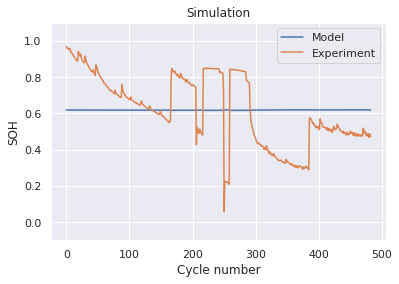

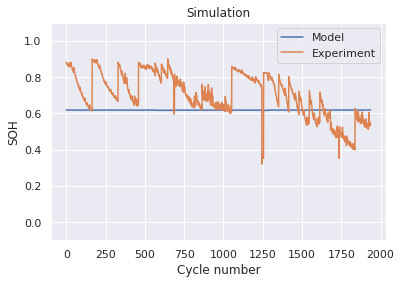

In [ ]:
# Model 
HIDDEN_DIM = 50
DROPOUT = 0
pool_type = 'bi_mean'

# Definition of the model (should agree with LSTM_version and LSTM_variant)
# LSTM_variant dictates the module: chemistry: chem., with norm: wn.
# LSTM_version dictates the version: 1 - 3 is LSTM_v1, 4 - 5 is LSTM_v4

Model = LSTM_v4(DELTA, HIDDEN_DIM, pooling_layer=pool_type, 
               drop_out=DROPOUT, version = LSTM_version,
               norm = train_dataset.norm
               )

Model = Model.to(device)
# Preview of the model's performance as is (should be bad for untrained models):
simulate(sim_train_loader, Model, device=device, denormalize=True)
simulate(valid_loader, Model, device=device, denormalize=True)

1 . Training loss:  tensor(0.9947)
1 . Validation loss:  tensor(0.5609)
2 . Training loss:  tensor(0.9728)
2 . Validation loss:  tensor(0.5426)
3 . Training loss:  tensor(0.9488)
3 . Validation loss:  tensor(0.5212)
4 . Training loss:  tensor(0.9212)
4 . Validation loss:  tensor(0.4947)
5 . Training loss:  tensor(0.8889)
5 . Validation loss:  tensor(0.4635)
6 . Training loss:  tensor(0.8507)
6 . Validation loss:  tensor(0.4249)
7 . Training loss:  tensor(0.8066)
7 . Validation loss:  tensor(0.3816)
8 . Training loss:  tensor(0.7592)
8 . Validation loss:  tensor(0.3366)
9 . Training loss:  tensor(0.7108)
9 . Validation loss:  tensor(0.2916)
10 . Training loss:  tensor(0.6628)
10 . Validation loss:  tensor(0.2497)
11 . Training loss:  tensor(0.6174)
11 . Validation loss:  tensor(0.2127)
12 . Training loss:  tensor(0.5761)
12 . Validation loss:  tensor(0.1826)
13 . Training loss:  tensor(0.5390)
13 . Validation loss:  tensor(0.1583)
14 . Training loss:  tensor(0.5061)
14 . Validation loss

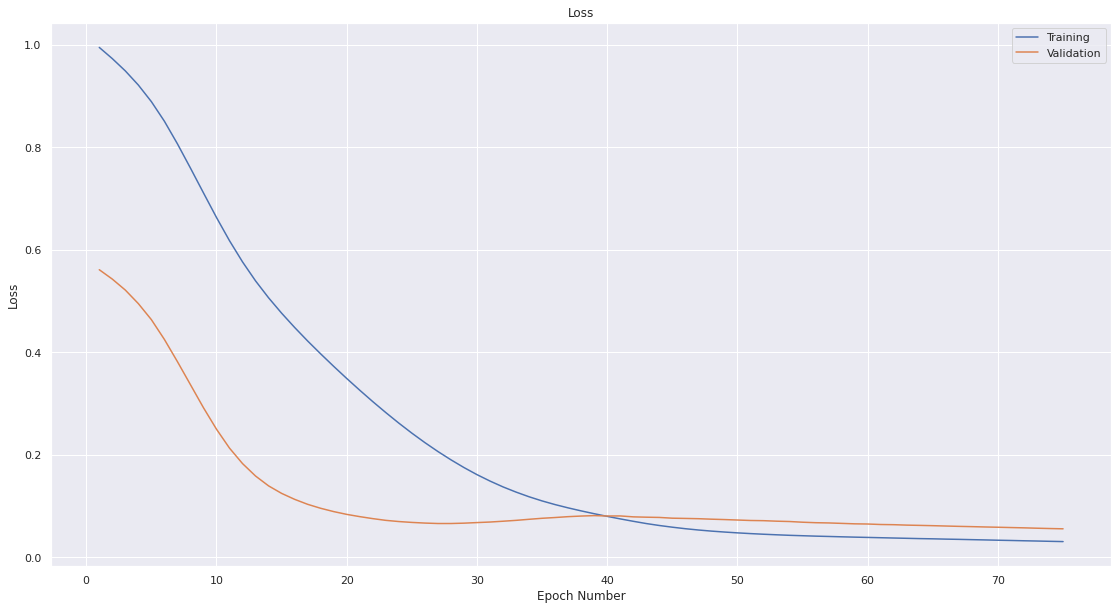

Best validation error:  75


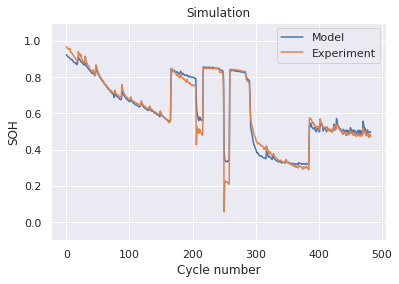

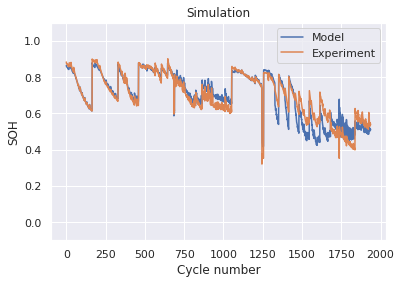

In [ ]:
# Training loop:
Nb_Epochs = 75          ###
Learning_Rate = 5e-6    ###


Train_info, _, _, date = Train(
    train_loader, valid_loader, Model, Nb_Epochs, plot_bool=True,
    LR=Learning_Rate, report=True, sim_loader=None, print_bool=True,
    device=device, remove_bool=True
    )

if Model.variant == 'with norm':
    # updating the Model's norm attribute after training in case report=False:
    Model.update_norm()

# Best epoch's performance:
simulate(sim_train_loader, Model, block=False, denormalize=True, device=device)
simulate(valid_loader, Model, block=False, denormalize=True, device=device)

In [ ]:
# Calculating the model's error for each battery separately:
Load_Save(date, device=device, dataset_name=dataset_name, denormalize_bool=False)

if dataset_name == 'MIT':
    Load_Save_v2(date, dataset_name, device=device,
                 time_step=train_dataset.time_step, norm_test='Model',
                 cycle_lim=cycle_lim, denormalize_bool=False)

B0005
165
B0006
166
B0007
165
B0018
130
B0025
27
B0026
24
B0027
27
B0028
27
B0029
40
B0030
40
B0031
40
B0032
40
B0033
180
B0034
188
B0036
192
B0038
44
B0039
42
B0040
43
B0041
25
B0042
64
B0043
64
B0044
65
B0045
68
B0046
66
B0047
67
B0048
68
B0053
55
B0054
101
B0055
98
B0056
100
B0005.txt
B0006.txt (used in training)
B0007.txt
B0018.txt
B0025.txt
B0026.txt
B0027.txt
B0028.txt
B0029.txt
B0030.txt (used in training)
B0031.txt
B0032.txt
B0033.txt
B0034.txt
B0036.txt
B0038.txt (used in training)
B0039.txt (used in training)
B0040.txt
B0041.txt (used in training)
B0042.txt
B0043.txt
B0044.txt
B0045.txt (used in training)
B0046.txt
B0047.txt
B0048.txt
B0053.txt
B0054.txt
B0055.txt (used in training)
B0056.txt
B0005.txt
B0006.txt (used in training)
B0007.txt
B0018.txt
B0025.txt
B0026.txt
B0027.txt
B0028.txt
B0029.txt
B0030.txt (used in training)
B0031.txt
B0032.txt
B0033.txt
B0034.txt
B0036.txt
B0038.txt (used in training)
B0039.txt (used in training)
B0040.txt
B0041.txt (used in training)
B00

In [ ]:
# Optional : evaluating the model's performance for each dataset:

# Adapt the following code to your needs:
# Read Load_Save_v2's documentation to know more. Most importantly,
# read about the time_step, norm_test variables.
# for dataset_name in ['NASA', 'MIT', 'Tarascon Coin']:
#     Load_Save_v2(date, dataset_name, device=device, 
#                 time_step=train_dataset.time_step, norm_test='Model',
#                 cycle_lim=cycle_lim, denormalize_bool=False)